In [1]:
import math
import pandas as pd
import torch
import torch.nn as nn
import sys
sys.path.append('..')
import myd2l

In [2]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_inputs, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_inputs, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
    
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [4]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = myd2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X , self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [5]:
class TransformerEncoder(myd2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = myd2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                'block' + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias)
            )
    
    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        
        return X

In [6]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
X = torch.ones((2, 100), dtype=torch.long)
valid_lens = torch.tensor([3, 2])
print(encoder(X, valid_lens).shape)

torch.Size([2, 100, 24])


In [7]:
class DecoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_inputs, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = myd2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = myd2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_inputs, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values

        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps + 1, device = X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)        
        Z2 = self.ffn(Z)
        return self.addnorm3(Z, Z2), state
        

In [8]:
class TransformerDecoder(myd2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_inputs, ffn_num_hiddens, num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encodings = myd2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                'block' + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_inputs, ffn_num_hiddens, num_heads, dropout, i)
            )
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encodings(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

epoch 1, loss 2.3428
epoch 10, loss 1.1084
epoch 20, loss 0.7446
epoch 30, loss 0.5347
epoch 40, loss 0.4055
epoch 50, loss 0.3328
epoch 60, loss 0.2744
epoch 70, loss 0.2382
epoch 80, loss 0.2148
epoch 90, loss 0.1931
epoch 100, loss 0.1678
epoch 110, loss 0.1611
epoch 120, loss 0.1534
epoch 130, loss 0.1465
epoch 140, loss 0.1383
epoch 150, loss 0.1353
epoch 160, loss 0.1361
epoch 170, loss 0.1392
epoch 180, loss 0.1225
epoch 190, loss 0.1269
epoch 200, loss 0.1201


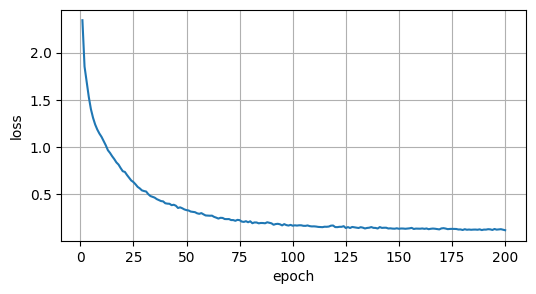

loss 0.1201, 10386.7 tokens/sec on cuda


In [9]:
num_hiddens, num_layers, dropout = 32, 2, 0.1,
lr, num_epochs, device = 0.005, 200, torch.device('cuda')
ffn_num_inputs, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

batch_size, num_steps = 64, 10
train_iter, src_vocab, tgt_vocab = myd2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_inputs, ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_inputs, ffn_num_hiddens, num_heads, num_layers, dropout)
net = myd2l.EncoderDecoder(encoder, decoder)
myd2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)



In [10]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = myd2l.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, bleu {myd2l.bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est mouillé ., bleu 0.658
i'm home . => je suis chez moi ., bleu 1.000


torch.Size([2, 4, 10, 10])


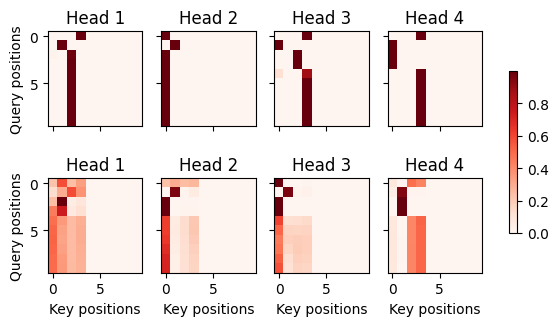

In [17]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads, num_steps, num_steps))
print(enc_attention_weights.shape)

myd2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions', ylabel='Query positions', titles=[f'Head {i}' for i in range(1, 5)], figsize=(7, 3.5))

In [37]:
dec_attention_weights_2d = [head[0].tolist() for step in dec_attention_weight_seq for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(1, 2, 3, 0, 4)
print(dec_self_attention_weights.shape, dec_inter_attention_weights.shape)

torch.Size([2, 4, 6, 10]) torch.Size([2, 4, 6, 10])


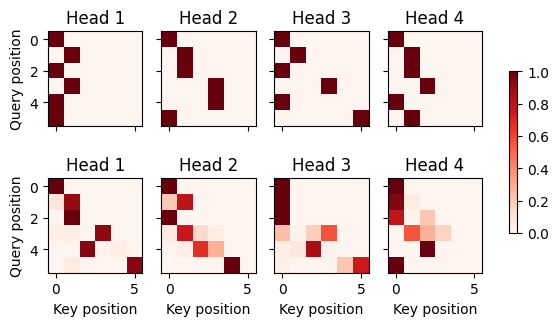

In [40]:
myd2l.show_heatmaps(dec_self_attention_weights[:, :, :, : len(translation.split()) + 1], xlabel='Key position', ylabel='Query position', titles=[f'Head {i}' for i in range(1, 5)], figsize=(7, 3.5))

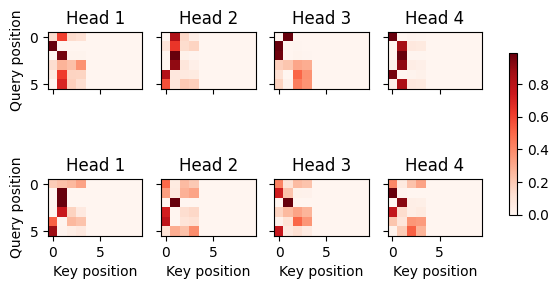

In [41]:
myd2l.show_heatmaps(dec_inter_attention_weights, xlabel='Key position', ylabel='Query position', titles=[f'Head {i}' for i in range(1, 5)], figsize=(7, 3.5))